# Проект для «Викишоп»

## Подготовка

Подключаем все неоходимые библиотеки

In [26]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')
import nltk
from nltk.stem import WordNetLemmatizer
import re

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression  
from sklearn.metrics import f1_score

from sklearn.utils import shuffle

[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Импортируем датасет методом read_csv() в переменную df, выводим общую информацию методом info(), выведем первые 5 строк датафрейма методом head()

In [2]:
df = pd.read_csv('/datasets/toxic_comments.csv')
df.info()
df.sample(10, random_state = 12345)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
text     159571 non-null object
toxic    159571 non-null int64
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
146790,Ahh shut the fuck up you douchebag sand nigger...,1
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0
115087,"Reply\nHey, you could at least mention Jasenov...",0
48830,"Thats fine, there is no deadline ) chi?",0
136034,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0
121992,"""\n\nSockpuppetry case\n \nYou have been accus...",0
37282,"Judging by what I've just read in an article, ...",0
64488,Todd and Copper\nIn the first film they were l...,0
16992,"""\n\n \nYou have been blocked from editing for...",0
138230,| decline=Can't find evidence of block either ...,0


In [3]:
df.duplicated().sum()

0

In [4]:
df.isna().sum()

text     0
toxic    0
dtype: int64

Для удобства дальнейшего анализа добавим столбец lemm с очищенным и лемматизированным текстом столбца text.

In [5]:
def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [6]:
def clear_text(text):
    result = re.sub(r'[^a-zA-Z ]', ' ', text)
    result = " ".join(result.split())
    return result

In [7]:
df['lemm'] = df['text'].apply(clear_text, lemmatize)
df.sample(10, random_state = 12345)

,text,toxic,lemm
146790,Ahh shut the fuck up you douchebag sand nigger...,1,Ahh shut the fuck up you douchebag sand nigger...
2941,"""\n\nREPLY: There is no such thing as Texas Co...",0,REPLY There is no such thing as Texas Commerce...
115087,"Reply\nHey, you could at least mention Jasenov...",0,Reply Hey you could at least mention Jasenovac...
48830,"Thats fine, there is no deadline ) chi?",0,Thats fine there is no deadline chi
136034,"""\n\nDYK nomination of Mustarabim\n Hello! You...",0,DYK nomination of Mustarabim Hello Your submis...
121992,"""\n\nSockpuppetry case\n \nYou have been accus...",0,Sockpuppetry case You have been accused of soc...
37282,"Judging by what I've just read in an article, ...",0,Judging by what I ve just read in an article t...
64488,Todd and Copper\nIn the first film they were l...,0,Todd and Copper In the first film they were li...
16992,"""\n\n \nYou have been blocked from editing for...",0,You have been blocked from editing for a perio...
138230,| decline=Can't find evidence of block either ...,0,decline Can t find evidence of block either as...


Рассмотрим соотношение классов с помощью метода value_counts().

In [8]:
df['toxic'].value_counts(normalize = True)

0    0.898321
1    0.101679
Name: toxic, dtype: float64

Визуализируем слова из разных классов с помощью метода WordCloud().

In [9]:
df_0 = df.query('toxic == 0')
df_1 = df.query('toxic == 1')

text_0 = df_0['lemm'].str.cat(sep = ' ')
text_1 = df_1['lemm'].str.cat(sep = ' ')

In [10]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud)
    plt.axis('off')

In [12]:
def wc(text):
    wordcloud = WordCloud(width = 3000, 
                          height = 2000, 
                          random_state = 12345, 
                          background_color = 'salmon', 
                          colormap = 'Pastel1', 
                          collocations = False, 
                          stopwords = STOPWORDS).generate(text)

    plot_cloud(wordcloud)

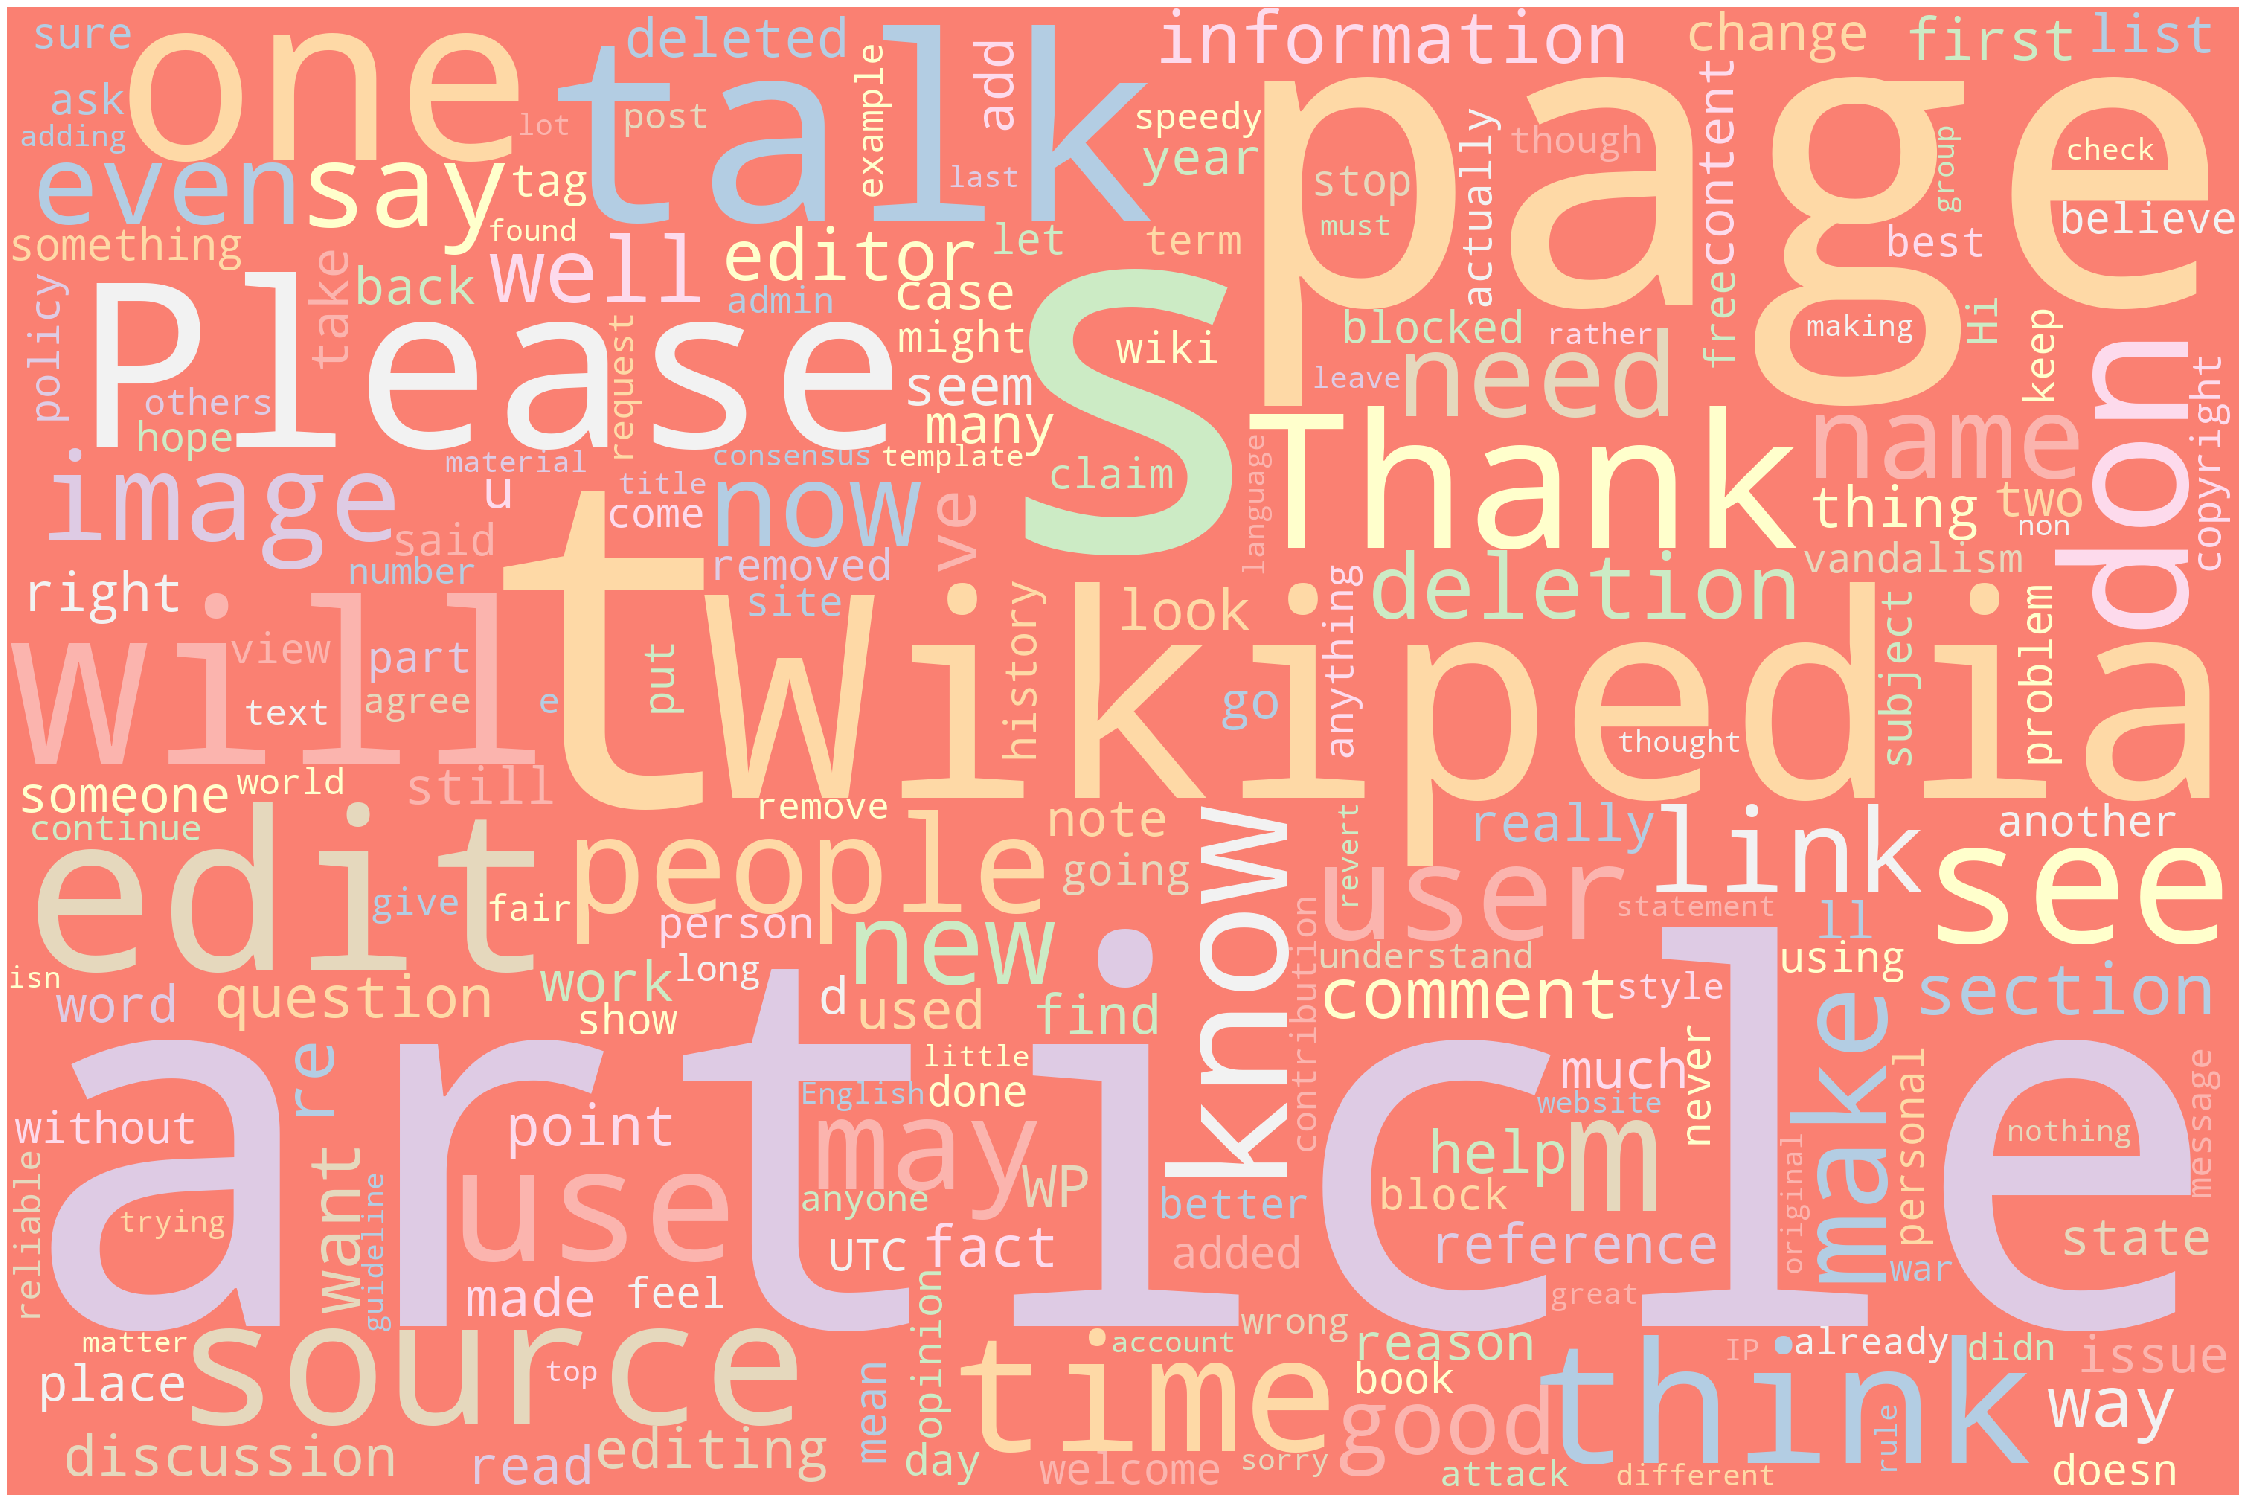

In [13]:
wc(text_0)

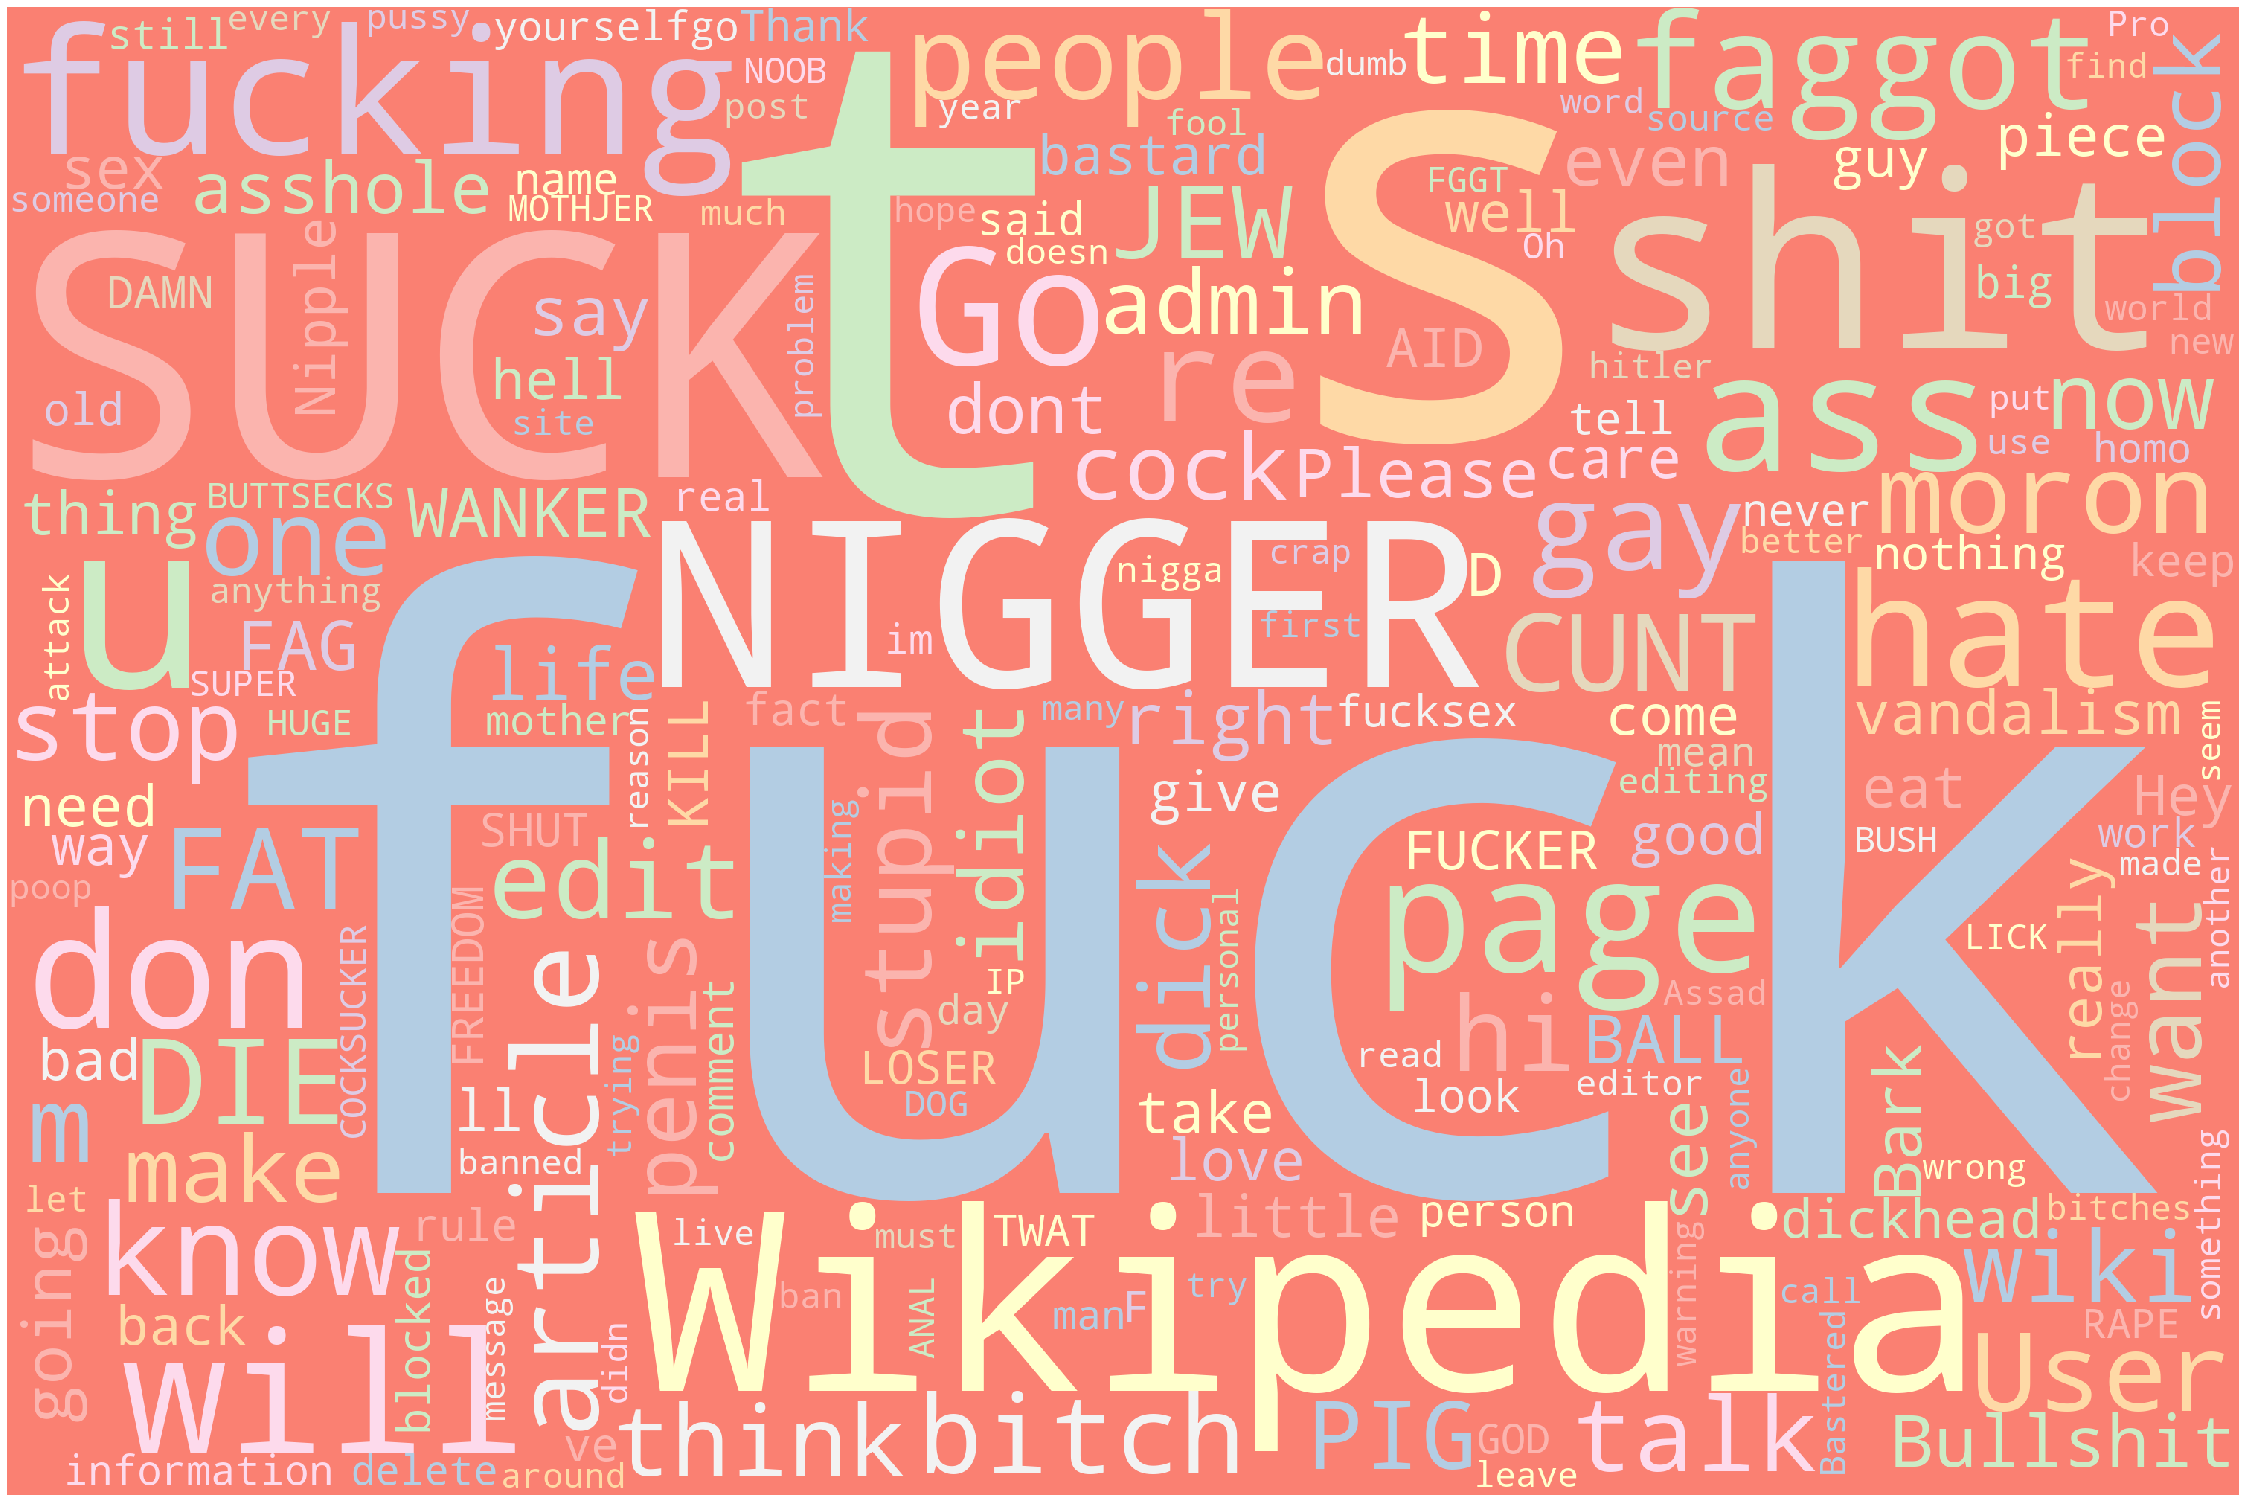

In [14]:
wc(text_1)

### Вывод

Данные были импортированны методом read_csv() в переменную df, по общей информации, полученной с помощью методов info(), duplicated(), isna() можно сделать вывод, что данные корректны, не содержат дубликатов и пропусков и не нуждаются в дополнительной предобработке.

Для удобства дальнейшего анализа был добавлен столбец lemm с очищенным и лемматизированным текстом столбца text. 

Было рассмотренно соотноошение классов, в итоге, можно сказать, что негативные комментарии составляют 10% данных.

Были визуализированны слова из разных классов с помощью метода WordCloud().

## Обучение

Разделим данные на обущающую и тестовую выборку в отношении 4:1 методом train_test_split. Выделим отдельно переменные с целевым признаком для каждой выбокри.

In [15]:
features = df['lemm']
target = df['toxic']

In [16]:
features_train, features_temp, target_train, target_temp = train_test_split(features, target, test_size = 0.2, random_state = 12345, stratify = target)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size = 0.5, random_state = 12345, stratify = target_temp)

In [16]:
features_train.shape

(127656,)

In [17]:
target_train.shape

(127656,)

In [18]:
features_valid.shape

(15957,)

In [19]:
target_valid.shape

(15957,)

In [20]:
features_test.shape

(15958,)

In [21]:
target_test.shape

(15958,)

Найдем TF-IDF.

In [17]:
count_tf_idf = TfidfVectorizer(stop_words = stopwords)

# tf_idf для трейна
corpus = features_train.values
tf_idf = count_tf_idf.fit_transform(corpus)

# tf_idf_valid для валид
corpus_valid = features_valid.values
tf_idf_valid = count_tf_idf.transform(corpus_valid)

# tf_idf_test для теста
corpus_test = features_test.values
tf_idf_test = count_tf_idf.transform(corpus_test)

### Рассмотрим работу разных моделей на различных балансировках классов

#### Дерево решений

In [18]:
# дерево решений
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345)
    model.fit(tf_idf, target_train)
    predicted = model.predict(tf_idf_valid)
    result = f1_score(predicted, target_valid)
    if result > best_result:
        best_depth = depth
        best_result = result
        
print('DecisionTreeClassifier')
print('Best F1:', best_result)
print('Best depth:', best_depth)

DecisionTreeClassifier
Best F1: 0.5864535128313
Best depth: 10


In [19]:
# дерево решений
best_result = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(max_depth = depth, random_state = 12345, class_weight = 'balanced')
    model.fit(tf_idf, target_train)
    predicted = model.predict(tf_idf_valid)
    result = f1_score(predicted, target_valid)
    if result > best_result:
        best_depth = depth
        best_result = result
        
print('DecisionTreeClassifier')
print('Best F1:', best_result)
print('Best depth:', best_depth)

DecisionTreeClassifier
Best F1: 0.5498310810810811
Best depth: 10


Тестируем лучшую модель

In [20]:
model = DecisionTreeClassifier(max_depth = 10, random_state = 12345)
model.fit(tf_idf, target_train)
predicted = model.predict(tf_idf_test)
result = f1_score(predicted, target_test)
print('F1:', result)

F1: 0.5619128949615714


##### Вывод

Была рассмотрена работа модели DecisionTreeClassifier, в результате были полученны следующие результаты:

- DecisionTreeClassifier:
    - Best F1: 0.5864535128313
    - Best depth: 10
- DecisionTreeClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.5498310810810811
    - Best depth: 10
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает лишь проигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.5619128949615714

#### Случайный лес

In [21]:
# случайный лес
best_result = 0
for est in range(10, 100, 5):
    for depth in range(1, 20):
        model = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state = 12345)
        model.fit(tf_idf, target_train)
        predicted = model.predict(tf_idf_valid)
        result = f1_score(predicted, target_valid)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print('RandomForestClassifier')
print('Best F1:', best_result)
print('Best est:', best_est)
print('Best depth:', best_depth)

RandomForestClassifier
Best F1: 0.015902140672782877
Best est: 10
Best depth: 19


In [23]:
# случайный лес
best_result = 0
for est in range(10, 100, 5):
    for depth in range(1, 20):
        model = RandomForestClassifier(n_estimators = est, max_depth = depth, random_state = 12345, class_weight = 'balanced')
        model.fit(tf_idf, target_train)
        predicted = model.predict(tf_idf_valid)
        result = f1_score(predicted, target_valid)
        if result > best_result:
            best_result = result
            best_est = est
            best_depth = depth

print('RandomForestClassifier')
print('Best F1:', best_result)
print('Best est:', best_est)
print('Best depth:', best_depth)

RandomForestClassifier
Best F1: 0.3981427742309924
Best est: 95
Best depth: 19


Тестируем лучшую модель.

In [25]:
model = RandomForestClassifier(n_estimators = 95, max_depth = 19, random_state = 12345, class_weight = 'balanced')
model.fit(tf_idf, target_train)
predicted = model.predict(tf_idf_test)
result = f1_score(predicted, target_test)

print('F1:', result)

F1: 0.4038851841113366


##### Вывод

Была рассмотрена работа модели RandomForestClassifier, в результате были полученны следующие результаты:

- RandomForestClassifier:
    - Best F1: 0.015902140672782877
    - Best est: 10
    - Best depth: 19
- RandomForestClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.3981427742309924
    - Best est: 95
    - Best depth: 19
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает значительный выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.4038851841113366

#### Логистическая регрессия

In [31]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear')
model.fit(tf_idf, target_train)
predicted = model.predict(tf_idf_valid)
result = f1_score(target_valid, predicted)

print('LogisticRegression')
print('F1:', result)

LogisticRegression
F1: 0.7354260089686099


In [30]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
model.fit(tf_idf, target_train)
predicted = model.predict(tf_idf_valid)
result = f1_score(target_valid, predicted)

print('LogisticRegression')
print('F1:', result)

LogisticRegression
F1: 0.7627906976744186


Тестируем лучшую модель.

In [33]:
model = LogisticRegression(random_state = 12345, solver = 'liblinear', class_weight = 'balanced')
model.fit(tf_idf, target_train)
predicted = model.predict(tf_idf_test)
result = f1_score(target_test, predicted)

print('LogisticRegression')
print('F1:', result)

LogisticRegression
F1: 0.7561857103141507


##### Вывод

Была рассмотрена работа модели LogisticRegression, в результате были полученны следующие результаты:

- LogisticRegression:
    - Best F1: 0.7354260089686099
- LogisticRegression с переметром class_weight = 'balanced':
    - Best F1: 0.7627906976744186
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает небольшой выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.7561857103141507

### Вывод

Имея целью достичь наилучшего качества предсказания были рассмотренны несколько моделей на различных гиперпараметрах.

Была рассмотрена работа модели DecisionTreeClassifier, в результате были полученны следующие результаты:

- DecisionTreeClassifier:
    - Best F1: 0.5864535128313
    - Best depth: 10
- DecisionTreeClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.5498310810810811
    - Best depth: 10
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает лишь проигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.5619128949615714

Была рассмотрена работа модели RandomForestClassifier, в результате были полученны следующие результаты:

- RandomForestClassifier:
    - Best F1: 0.015902140672782877
    - Best est: 10
    - Best depth: 19
- RandomForestClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.3981427742309924
    - Best est: 95
    - Best depth: 19
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает значительный выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.4038851841113366

Была рассмотрена работа модели LogisticRegression, в результате были полученны следующие результаты:

- LogisticRegression:
    - Best F1: 0.7354260089686099
- LogisticRegression с переметром class_weight = 'balanced':
    - Best F1: 0.7627906976744186
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает небольшой выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.7561857103141507

## Общий вывод

Цель: построить модель, способную наилучшем образом спрогнозировать, негатичный ли комментарий или нет. Для обучения моделей был предоставлен набор данных с разметкой о токсичности правок.

Задача: построить модель с предельно большим значением F1-меры (>0.75).

Работа была выполненна в несколько этапов:

**Подготовка**

Данные были импортированны методом read_csv() в переменную df, по общей информации, полученной с помощью методов info(), duplicated(), isna() можно сделать вывод, что данные корректны, не содержат дубликатов и пропусков и не нуждаются в дополнительной предобработке.

Для удобства дальнейшего анализа был добавлен столбец lemm с очищенным и лемматизированным текстом столбца text. 

Было рассмотренно соотноошение классов, в итоге, можно сказать, что негативные комментарии составляют 10% данных.

Были визуализированны слова из разных классов с помощью метода WordCloud().

**Обучение**

Имея целью достичь наилучшего качества предсказания были рассмотренны несколько моделей на различных гиперпараметрах.

Была рассмотрена работа модели DecisionTreeClassifier, в результате были полученны следующие результаты:

- DecisionTreeClassifier:
    - Best F1: 0.5864535128313
    - Best depth: 10
- DecisionTreeClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.5498310810810811
    - Best depth: 10
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает лишь проигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.5619128949615714

Была рассмотрена работа модели RandomForestClassifier, в результате были полученны следующие результаты:

- RandomForestClassifier:
    - Best F1: 0.015902140672782877
    - Best est: 10
    - Best depth: 19
- RandomForestClassifier с переметром class_weight = 'balanced':
    - Best F1: 0.3981427742309924
    - Best est: 95
    - Best depth: 19
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает значительный выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.4038851841113366

Была рассмотрена работа модели LogisticRegression, в результате были полученны следующие результаты:

- LogisticRegression:
    - Best F1: 0.7354260089686099
- LogisticRegression с переметром class_weight = 'balanced':
    - Best F1: 0.7627906976744186
    
По результатам работы модели на обущающей выборке можно заключить, что наличие параметра в данном случае дает небольшой выигрыш по качеству предстаканий, в результате тестирования модели с лучшими гиперпараметрами на тестовой выборке получим:
- F1: 0.7561857103141507

По полученным данным можно заключить, что наихудший результат показала модель RandomForestClassifier, наиболее подходящей же является модель LogisticRegression с переметром class_weight = 'balanced', на тестовой выборке метрика F1 превысила 0.75.

Таким образом задача проекта была выполенна, цель достигнута.